In [9]:
import os
from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d
from matplotlib import gridspec
%matplotlib inline
#plt.rcParams['figure.figsize'] = (12,8)
import pandas as pd
from time import sleep
import plotly.io as pio
from plotly.offline import init_notebook_mode
from skhep.visual import MplPlotter as splt
from copy import deepcopy
from lmfit import Model, Parameters, report_fit
from hallprobesim_redux import *
from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns

In [10]:
df_long_250mm = DataFrameMaker(mu2e_ext_path+'datafiles/FieldMapsCole/bfield_map_r250mm_p10cm_lengthx10_1232173pts_09-07_160736',input_type = 'pkl').data_frame
#df_short_250mm = DataFrameMaker(mu2e_ext_path+'datafiles/FieldMapsCole/bfield_map_1232173pts_08-10_094943',input_type = 'pkl').data_frame
df_short_250mm = DataFrameMaker(mu2e_ext_path+'datafiles/FieldMapsCole/v2_bfield_map_r250mm_p10cm_1232173pts_08-25_154402',input_type = 'pkl').data_frame

In [11]:
phi=3*np.pi/4
fig = mu2e_plot3d(df_short_250mm, 'R', 'Z', 'Bphi', f'R<0.15 and Phi=={phi} and -2<Z<2',
            title_simp = 'Btheta, Solenoid B', df_fit=False, mode='plotly_nb', ptype='3d', units='m', aspect='rect2',)
#pio.write_image(fig, '/Users/brianpollack/Documents/Notes_Papers/Helix/figs/fig_bt_B.png')

/home/ckampa/anaconda3/envs/bfitter/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:174: DeprecationWarning:

plotly.graph_objs.ColorBar is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.marker.ColorBar
  - plotly.graph_objs.surface.ColorBar
  - etc.




In [ ]:
#ff_list = []
cfg_params_Cole = cfg_params(ns=1, ms=2, cns=0, cms=0, nms=0, Reff=0.1,
                             n_scale=1, m_scale=1, func_version=120)

cfg_pickle_Cole = cfg_pickle(use_pickle=False, save_pickle=True,
                             load_name='phi_test', save_name='phi_test', recreate=False)

#for phi in tqdm_notebook((0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8), desc='phi'):
#for phi in tqdm_notebook((0,), desc='phi'):

hmd, ff = field_map_analysis('halltoy_phi_test', cfg_data_DS_Cole_Hel_10x2,
                                  cfg_geom_hel_250mm2, cfg_params_Cole,
                                  cfg_pickle_Cole, cfg_plot_none)
#ff_list.append(ff)

In [191]:
phi=0.463648
df_long_250mm[np.isclose(df_long_250mm.Phi, phi)].R.unique()

array([0.02795085, 0.0559017 , 0.08385255, 0.1118034 , 0.13975425,
       0.1677051 , 0.19565595, 0.2236068 , 0.25155765, 0.2795085 ])

In [199]:
df_fs =ff_fullsim.input_data

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
_ = splt.hist((df_fs.Bz-df_fs.Bz_fit)*1e4, ax=ax[0])
ax[0].set_title('Bz')
ax[0].set_ylabel('Counts')
_ = splt.hist((df_fs.Br-df_fs.Br_fit)*1e4, ax=ax[1])
ax[1].set_title('Br')
_ = splt.hist((df_fs.Bphi-df_fs.Bphi_fit)*1e4, ax=ax[2])
ax[2].set_title('Btheta')
fig.suptitle('B Component Residuals')
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/fig_res_A.pdf')

# Determining Optimal Number of Free Params

In [5]:
ff.result.redchi
ff.result.chisqr

0.005791691236151227

In [5]:
# Must use method='leastsq', aka LM.  method='least_squares' aka trust region reflective, does not converge well
df_aic = pd.DataFrame(columns=['ms', 'ns', 'AIC', 'chi2', 'redchi'])
ms = range(1,6)
ns = list(range(1,6))
do_pickle=False
for m in tqdm_notebook(ms, desc='ms'):
    for n in tqdm_notebook(ns, desc='ns'):
        cfg_pickle_Opt = cfg_pickle(use_pickle=do_pickle, save_pickle=True,
                                     load_name='opt_test', save_name='opt_test', recreate=False)
        cfg_params_Hel_Opt  = cfg_params(pitch1=0.1, ms_h1=m, ns_h1=n,
                                         pitch2=0, ms_h2=0, ns_h2=0,
                                         length1=0, ms_c1=0, ns_c1=0,
                                         length2=0, ms_c2=0, ns_c2=0,
                                          ks_dict={'k3': 768},
                                          bs_tuples=((0.25, 0, -46),
                                                     (0.25, 0, 46)),
                                          bs_bounds=(0.1, 0.1, 4),
                                         version=1000)
        hmd, ff = field_map_analysis('fma_opt_test', cfg_data_Cole_250mm_long_cyl,
                                          cfg_geom_Cole_250mm_cyl, cfg_params_Hel_Opt,
                                          cfg_pickle_Opt, cfg_plot_none)
        df_aic = df_aic.append({'ms':m, 'ns':n, 'AIC':np.log(-ff.result.aic),
                               'chi2':ff.result.chisqr, 'redchi':ff.result.redchi}, ignore_index=True)
        do_pickle=False

HBox(children=(IntProgress(value=0, description='ms', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ns', max=5), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=1, ns_h1=1, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 5.54965 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 17280
    # variables        = 15
    chi-square         = 2403.22211
    reduced chi-square = 0.13920
    Akaike info crit   = -34058.93649
    Bayesian info crit = -33942.57692
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     1 (fixed)
    ns_h1:     1 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:   1.2792e-10 +/- 0        (0.00%) (init=-

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=1, ns_h1=5, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 5.73923 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 17280
    # variables        = 23
    chi-square         = 0.00579
    reduced chi-square = 0.00000
    Akaike info crit   = -257572.75282
    Bayesian info crit = -257394.33481
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     1 (fixed)
    ns_h1:     5 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -4.3748e-12 +/- 0        (0.00%) (init=-1

HBox(children=(IntProgress(value=0, description='ns', max=5), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=2, ns_h1=1, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 5.2654 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 17280
    # variables        = 17
    chi-square         = 2403.22398
    reduced chi-square = 0.13921
    Akaike info crit   = -34054.92307
    Bayesian info crit = -33923.04888
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     2 (fixed)
    ns_h1:     1 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:   2.0044e-10 +/- 0        (0.00%) (init=-1

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=2, ns_h1=5, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 11.6331 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 549
    # data points      = 17280
    # variables        = 33
    chi-square         = 0.00000
    reduced chi-square = 0.00000
    Akaike info crit   = -379724.28444
    Bayesian info crit = -379468.29337
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     2 (fixed)
    ns_h1:     5 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -5.7090e-12 +/- 0        (0.00%) (init=-1

HBox(children=(IntProgress(value=0, description='ns', max=5), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=3, ns_h1=1, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 7.68652 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 318
    # data points      = 17280
    # variables        = 19
    chi-square         = 2403.23649
    reduced chi-square = 0.13923
    Akaike info crit   = -34050.83309
    Bayesian info crit = -33903.44429
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     3 (fixed)
    ns_h1:     1 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:   1.0363e-09 +/- 0        (0.00%) (init=-

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=3, ns_h1=4, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 8.98052 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 313
    # data points      = 17280
    # variables        = 37
    chi-square         = 0.00000
    reduced chi-square = 0.00000
    Akaike info crit   = -379741.26177
    Bayesian info crit = -379454.24148
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     3 (fixed)
    ns_h1:     4 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -1.1862e-11 +/- 0        (0.00%) (init=-1

HBox(children=(IntProgress(value=0, description='ns', max=5), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=4, ns_h1=1, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 10.7211 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 543
    # data points      = 17280
    # variables        = 21
    chi-square         = 2403.22512
    reduced chi-square = 0.13924
    Akaike info crit   = -34046.91487
    Bayesian info crit = -33884.01147
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     4 (fixed)
    ns_h1:     1 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:   2.7385e-09 +/- 0        (0.00%) (init=-

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=4, ns_h1=4, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 10.1088 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 376
    # data points      = 17280
    # variables        = 45
    chi-square         = 0.00000
    reduced chi-square = 0.00000
    Akaike info crit   = -379732.55229
    Bayesian info crit = -379383.47356
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     4 (fixed)
    ns_h1:     4 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -9.1904e-12 +/- 0        (0.00%) (init=-1

HBox(children=(IntProgress(value=0, description='ns', max=5), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=5, ns_h1=1, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 8.76463 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 373
    # data points      = 17280
    # variables        = 23
    chi-square         = 2413.47897
    reduced chi-square = 0.13986
    Akaike info crit   = -33969.34309
    Bayesian info crit = -33790.92507
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     5 (fixed)
    ns_h1:     1 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:   4.2139e-05 +/- 0        (0.00%) (init=-

fitting with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=5, ns_h1=4, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 13.6921 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 549
    # data points      = 17280
    # variables        = 53
    chi-square         = 0.00000
    reduced chi-square = 0.00000
    Akaike info crit   = -379729.92273
    Bayesian info crit = -379318.78556
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     5 (fixed)
    ns_h1:     4 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -2.4185e-11 +/- 0        (0.00%) (init=-1

In [3]:
df_aic_cyl = pd.DataFrame(columns=['ms', 'ns', 'AIC', 'chi2', 'redchi'])
ms = range(1,3)
ns = range(1,41,4)
for m in tqdm_notebook(ms, desc='ms'):
    do_pickle=False
    for n in tqdm_notebook(ns, desc='ns'):
        cfg_pickle_Opt = cfg_pickle(use_pickle=do_pickle, save_pickle=True,
                                     load_name='opt_test', save_name='opt_test', recreate=False)
        cfg_params_Cyl_Opt  = cfg_params(pitch1=0, ms_h1=0, ns_h1=0,
                                         pitch2=0, ms_h2=0, ns_h2=0,
                                         length1=0.05, ms_c1=m, ns_c1=n,
                                         length2=0, ms_c2=0, ns_c2=0,
                                         ks_dict={'k3':768},
                                         bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3),
                                                    (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)),
                                         bs_bounds=(1e-3, 1e-3, 5),
                                         version=1000)


        hmd, ff = field_map_analysis('fma_opt_test', cfg_data_Cole_250mm_long_cyl,
                                          cfg_geom_Cole_250mm_cyl, cfg_params_Cyl_Opt,
                                          cfg_pickle_Opt, cfg_plot_none)
        df_aic_cyl = df_aic_cyl.append({'ms':m, 'ns':n, 'AIC':np.log(-ff.result.aic),
                               'chi2':ff.result.chisqr, 'redchi':ff.result.redchi}, ignore_index=True)
        if n>=21:
            do_pickle=True
        else:
            do_pickle=False

HBox(children=(IntProgress(value=0, description='ms', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ns', max=10), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=1, ns_c1=1, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 3.64315 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 17280
    # variables        = 4
    chi-square         = 2403.33512
    reduced chi-square = 0.13911
    Akaike info crit   = -34080.12393
    Bayesian info crit = -34049.09471
[[Variables]]
    pitch1:    0 (fixed)
    ms_h1:     0 (fixed)
    ns_h1:     0 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0.05 (fixed)
    ms_c1:     1 (fixed)
    ns_c1:     1 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ac1_0

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=1, ns_c1=17, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 9.07099 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 380
    # data points      = 17280
    # variables        = 52
    chi-square         = 13.26171
    reduced chi-square = 0.00077
    Akaike info crit   = -123835.49492
    Bayesian info crit = -123432.11506
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      1 (fixed)
    ns_c1:      17 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=1, ns_c1=25, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 3.6785 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 17280
    # variables        = 76
    chi-square         = 0.66274
    reduced chi-square = 0.00004
    Akaike info crit   = -175562.71525
    Bayesian info crit = -174973.16007
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      1 (fixed)
    ns_c1:      25 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (fix

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=1, ns_c1=33, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 13.6733 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 615
    # data points      = 17280
    # variables        = 100
    chi-square         = 0.66274
    reduced chi-square = 0.00004
    Akaike info crit   = -175514.73316
    Bayesian info crit = -174739.00266
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      1 (fixed)
    ns_c1:      33 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (

Elapsed time was 4.69845 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 120
    # data points      = 17280
    # variables        = 112
    chi-square         = 0.66274
    reduced chi-square = 0.00004
    Akaike info crit   = -175490.73316
    Bayesian info crit = -174621.91500
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      1 (fixed)
    ns_c1:      37 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (fixed)
    Ac1_0_0:    0          +/- 0        (nan%) (init= 0)
    Bc1_0_0:    0          +/- 0        (nan%) (init= 0)
    Dc1_0:      1          +/- 0        (0.00%) (init= 1)
    Ac1_0_1:   -1.7660e-05 +/- 0        (0.00%) (init=-1.76598e-05)
    Bc1_0_1:   -1.2300e-06 +/- 0        (0.00%) (init=-1.229942e-06)
    Dc1_1:      0.93520427 +/- 0        (0.

HBox(children=(IntProgress(value=0, description='ns', max=10), HTML(value='')))

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=2, ns_c1=1, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 3.56128 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 17280
    # variables        = 6
    chi-square         = 2403.33512
    reduced chi-square = 0.13913
    Akaike info crit   = -34076.12393
    Bayesian info crit = -34029.58010
[[Variables]]
    pitch1:    0 (fixed)
    ms_h1:     0 (fixed)
    ns_h1:     0 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0.05 (fixed)
    ms_c1:     2 (fixed)
    ns_c1:     1 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ac1_0

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=2, ns_c1=13, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 5.79084 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 149
    # data points      = 17280
    # variables        = 66
    chi-square         = 1253.81534
    reduced chi-square = 0.07284
    Akaike info crit   = -45199.63641
    Bayesian info crit = -44687.65428
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      2 (fixed)
    ns_c1:      13 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=2, ns_c1=21, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 223.926 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10087
    # data points      = 17280
    # variables        = 106
    chi-square         = 0.65738
    reduced chi-square = 0.00004
    Akaike info crit   = -175643.16564
    Bayesian info crit = -174820.89130
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      2 (fixed)
    ns_c1:      21 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=2, ns_c1=29, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 238.415 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10015
    # data points      = 17280
    # variables        = 146
    chi-square         = 0.65796
    reduced chi-square = 0.00004
    Akaike info crit   = -175547.86526
    Bayesian info crit = -174415.29872
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      2 (fixed)
    ns_c1:      29 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=2, ns_c1=33, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 6.3156 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 174
    # data points      = 17280
    # variables        = 166
    chi-square         = 0.65796
    reduced chi-square = 0.00004
    Akaike info crit   = -175507.86526
    Bayesian info crit = -174220.15262
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      2 (fixed)
    ns_c1:      33 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (f

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=2, ns_c1=37, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.2494883, 0.0003228857, -46, -0.009278658, 0.01086116, -3), (0.2501242, -6.491774e-06, 46, 0.02531165, 0.01085981, -3)), bs_bounds=(0.001, 0.001, 5), version=1000)
Elapsed time was 107.759 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3938
    # data points      = 17280
    # variables        = 186
    chi-square         = 0.65795
    reduced chi-square = 0.00004
    Akaike info crit   = -175468.13197
    Bayesian info crit = -174025.27324
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      2 (fixed)
    ns_c1:      37 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 

In [24]:
df_aic.to_pickle('pickles/df_aic_hel_solA.pkl')
df_aic_cyl.to_pickle('pickles/df_aic_cyl_solA.pkl')

Text(0.5,1,'Fit Quality per Number of Terms (Helical Series)')

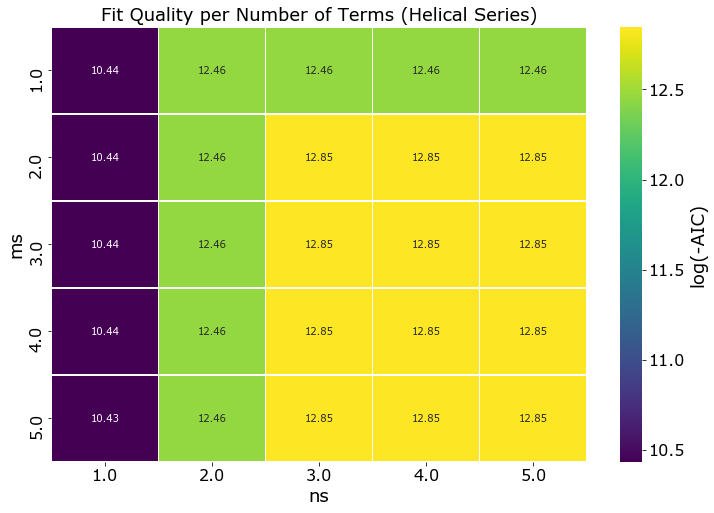

In [6]:
sns.heatmap(df_aic.query('ns>0 and ms>0').pivot('ms', 'ns', 'AIC'), annot=True, fmt='.2f', linewidths=.5, cmap='viridis',
           cbar_kws={'label': 'log(-AIC)'})
plt.title('Fit Quality per Number of Terms (Helical Series)')
#plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/aic_solA_helix.pdf')

In [23]:
df_aic.eval('logchi2 = log(chi2)', inplace=True)
df_aic_cyl.eval('logchi2 = log(chi2)', inplace=True)

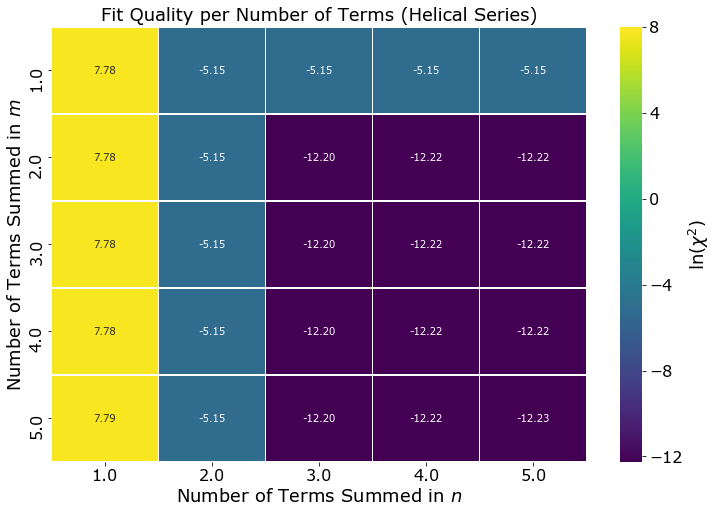

In [27]:
sns.heatmap(df_aic.query('ns>0 and ms>0').pivot('ms', 'ns', 'logchi2'), annot=True, fmt='.2f', linewidths=.5, cmap='viridis',
           cbar_kws={'label': r'$\ln(\chi^2)$'}, vmin=-12.25, vmax=8)
plt.title('Fit Quality per Number of Terms (Helical Series)')
plt.ylabel(r'Number of Terms Summed in $m$')
plt.xlabel(r'Number of Terms Summed in $n$')
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/chi2_solA_helix.pdf')

Text(0.5,1,'Fit Quality per Number of Terms (Cylindrical Series)')

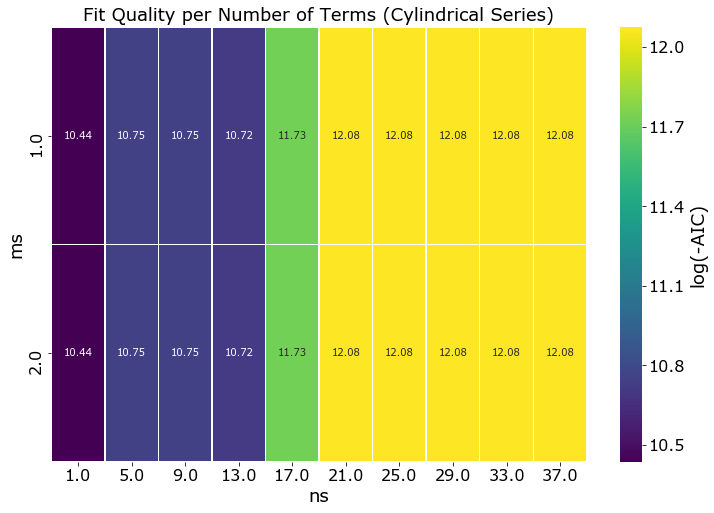

In [4]:
sns.heatmap(df_aic_cyl.query('ns>0').pivot('ms', 'ns', 'AIC'), annot=True, fmt='.2f', linewidths=.5, cmap='viridis',
           cbar_kws={'label': 'log(-AIC)'})
plt.title('Fit Quality per Number of Terms (Cylindrical Series)')
#plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/aic_solA_cyl.pdf')

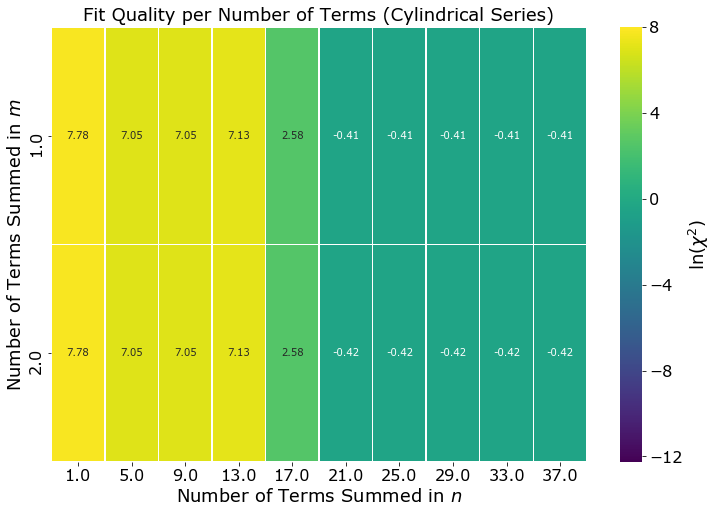

In [26]:
sns.heatmap(df_aic_cyl.query('ns>0 and ms>0').pivot('ms', 'ns', 'logchi2'), annot=True, fmt='.2f', linewidths=.5, cmap='viridis',
           cbar_kws={'label': r'$\ln(\chi^2)$'}, vmin=-12.25, vmax=8)
plt.title('Fit Quality per Number of Terms (Cylindrical Series)')
plt.ylabel(r'Number of Terms Summed in $m$')
plt.xlabel(r'Number of Terms Summed in $n$')
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/chi2_solA_cyl.pdf')
#plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/aic_solA_cyl.pdf')

# Fit Plots

## Helical Fits

In [28]:
cfg_pickle_Hel = cfg_pickle(use_pickle=False, save_pickle=True,
                             load_name='solA_fit_val', save_name='solA_fit_val', recreate=True)
cfg_params_Hel  = cfg_params(pitch1=0.1, ms_h1=2, ns_h1=3,
                                 pitch2=0, ms_h2=0, ns_h2=0,
                                 length1=0, ms_c1=0, ns_c1=0,
                                 length2=0, ms_c2=0, ns_c2=0,
                                 ks_dict={'k3': 768},
                                 bs_tuples=((0.25, 0, -46),
                                            (0.25, 0, 46)),
                                 bs_bounds=(0.1, 0.1, 4),
                                 version=1000)
_, ff_hel = field_map_analysis('fma_fit_solA', cfg_data_Cole_250mm_long_cyl,
                                  cfg_geom_Cole_250mm_cyl, cfg_params_Hel,
                                  cfg_pickle_Hel, cfg_plot_none)

recreating fit with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=2, ns_h1=3, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 2.57661 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 17280
    # variables        = 0
    chi-square         = 0.00001
    reduced chi-square = 0.00000
    Akaike info crit   = -379365.11230
    Bayesian info crit = -379365.11230
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     2 (fixed)
    ns_h1:     3 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -5.122011e-12 (fixed)
    Dh1_0_0:   

In [37]:
df_param_hel = pd.DataFrame(columns=['m', 'n', 'D', 'E'])
for m in range(2):
    for n in range(3):
        df_param_hel = df_param_hel.append({'m':m, 'n':n, 'D':ff_hel.params[f'Ch1_{m}_{n}'].value, 'E':ff_hel.params[f'Dh1_{m}_{n}'].value} ,ignore_index=True)
df_param_hel.eval('absD = abs(D)', inplace=True)
df_param_hel.eval('absE = abs(E)', inplace=True)
df_param_hel.eval('logD = log(absD)', inplace=True)
df_param_hel.eval('logE = log(absE)', inplace=True)
        

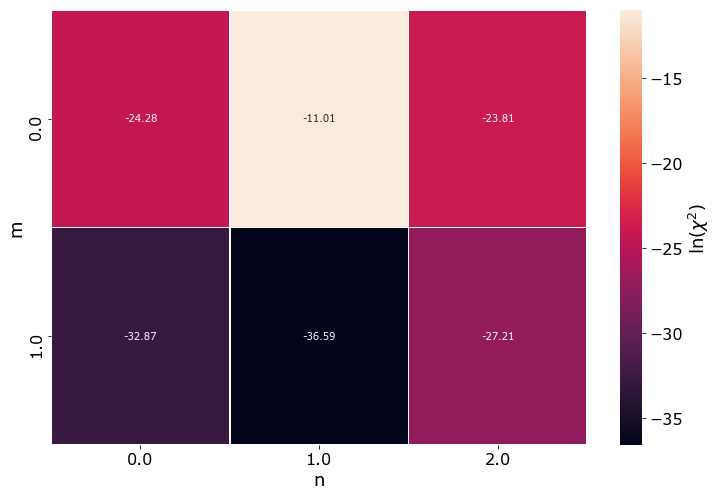

In [38]:
sns.heatmap(df_param_hel.pivot('m', 'n', 'logE'), annot=True, fmt='.2f', linewidths=.5,
           cbar_kws={'label': r'$\ln(\chi^2)$'})

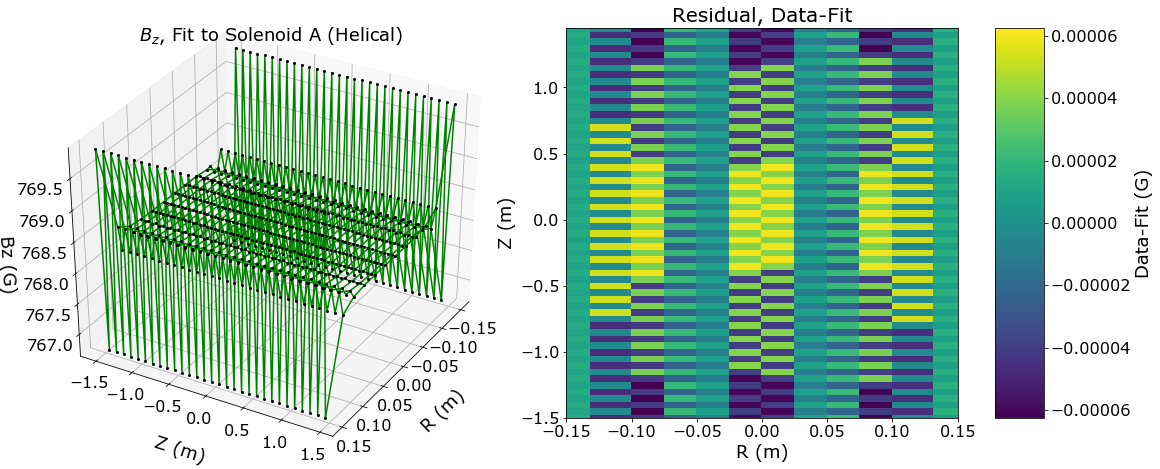

In [60]:
phi=0
fig = mu2e_plot3d(ff_hel.input_data, 'R', 'Z', 'Bz', f'R<=0.15 and Phi=={phi} and -2<Z<2',
            title_simp = r'$B_{z}$, Fit to Solenoid A (Helical)', df_fit=True, mode='mpl', ptype='3d', units='m', aspect='rect2', do2pi=True)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/hel_bz_A_fit.png', bbox_inches='tight' )

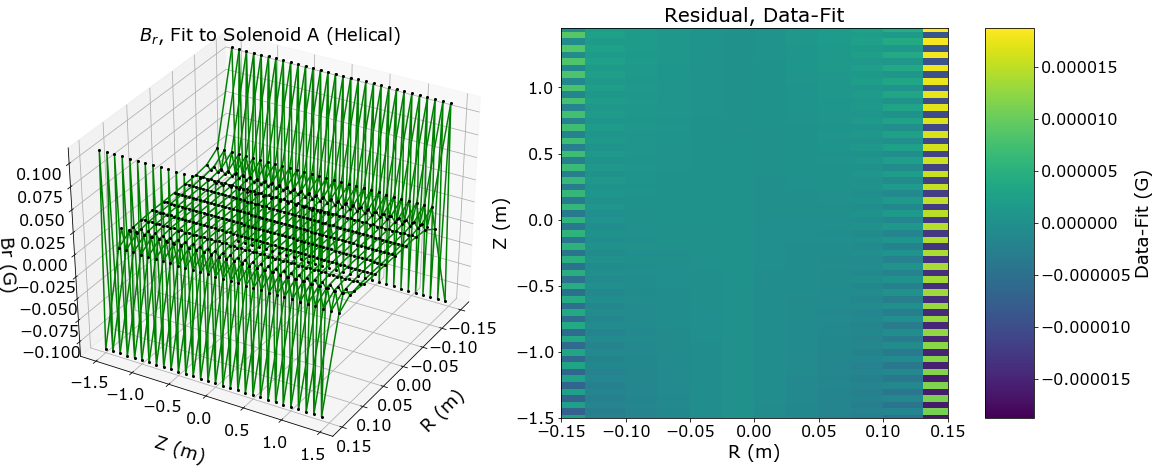

In [61]:
phi=0
fig = mu2e_plot3d(ff_hel.input_data, 'R', 'Z', 'Br', f'R<=0.15 and Phi=={phi} and -2<Z<2',
            title_simp = r'$B_{r}$, Fit to Solenoid A (Helical)', df_fit=True, mode='mpl', ptype='3d', units='m', aspect='rect2', do2pi=True)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/hel_br_A_fit.png', bbox_inches='tight')

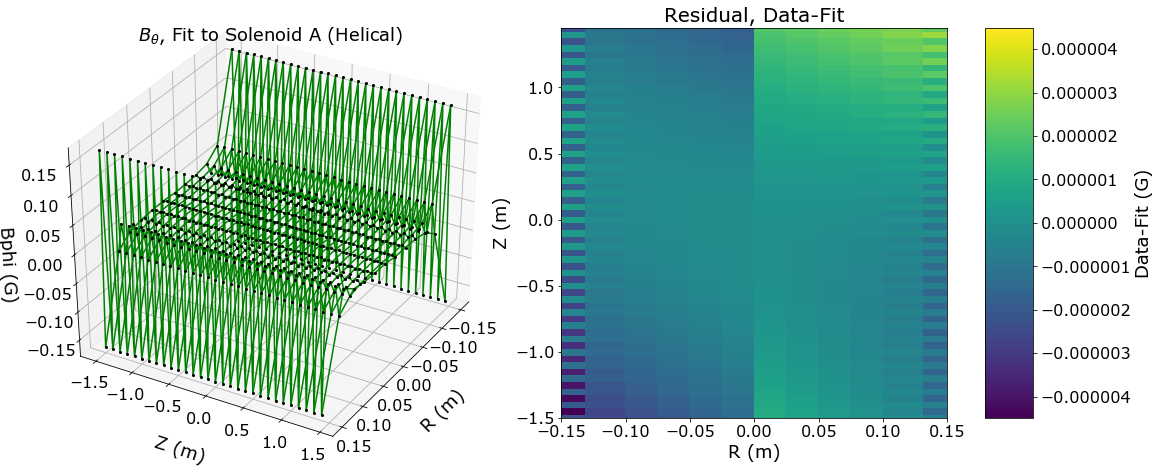

In [62]:
phi=0
fig = mu2e_plot3d(ff_hel.input_data, 'R', 'Z', 'Bphi', f'R<=0.15 and Phi=={phi} and -2<Z<2',
            title_simp = r'$B_{\theta}$, Fit to Solenoid A (Helical)', df_fit=True, mode='mpl', ptype='3d', units='m', aspect='rect2', do2pi=True)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/hel_bt_A_fit.png', bbox_inches='tight')

## Cylindrical Fits

In [51]:
cfg_pickle_Cyl = cfg_pickle(use_pickle=False, save_pickle=True,
                             load_name='solA_fit2_val', save_name='solA_fit2_val', recreate=True)
cfg_params_Cyl  = cfg_params(pitch1=0, ms_h1=0, ns_h1=0,
                                 pitch2=0, ms_h2=0, ns_h2=0,
                                 length1=0.05, ms_c1=1, ns_c1=21,
                                 length2=0, ms_c2=0, ns_c2=0,
                                 ks_dict={'k3': 768},
                                 bs_tuples=((0.25, 0, -46),
                                            (0.25, 0, 46)),
                                 bs_bounds=(1e-3, 1e-3, 3),
                                 version=1000)
_, ff_cyl = field_map_analysis('fma_fit2_solA', cfg_data_Cole_250mm_long_cyl,
                                  cfg_geom_Cole_250mm_cyl, cfg_params_Cyl,
                                  cfg_pickle_Cyl, cfg_plot_none)

fitting with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=1, ns_c1=21, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.001, 0.001, 3), version=1000)
Elapsed time was 99.3465 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5409
    # data points      = 17280
    # variables        = 76
    chi-square         = 0.66703
    reduced chi-square = 0.00004
    Akaike info crit   = -175451.14438
    Bayesian info crit = -174861.58919
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      1 (fixed)
    ns_c1:      21 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (fixed)
    Ac1_0_0:    0          +/- 0        (nan%) (init= 0)
    Bc1_0_0:    0          

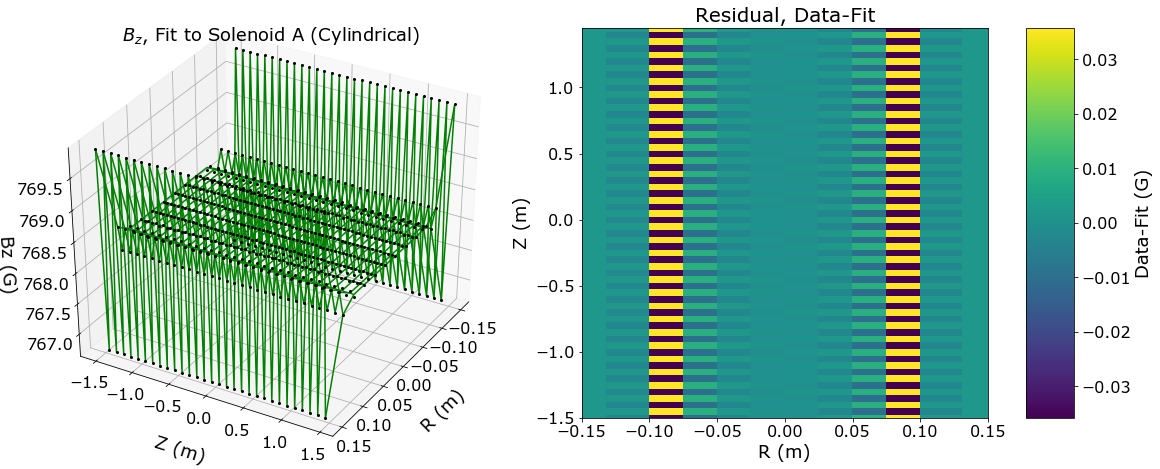

In [63]:
phi=0
fig = mu2e_plot3d(ff_cyl.input_data, 'R', 'Z', 'Bz', f'R<=0.15 and Phi=={phi} and -2<Z<2',
            title_simp = r'$B_{z}$, Fit to Solenoid A (Cylindrical)', df_fit=True, mode='mpl', ptype='3d', units='m', aspect='rect2', do2pi=True)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/cyl_bz_A_fit.png', bbox_inches='tight')

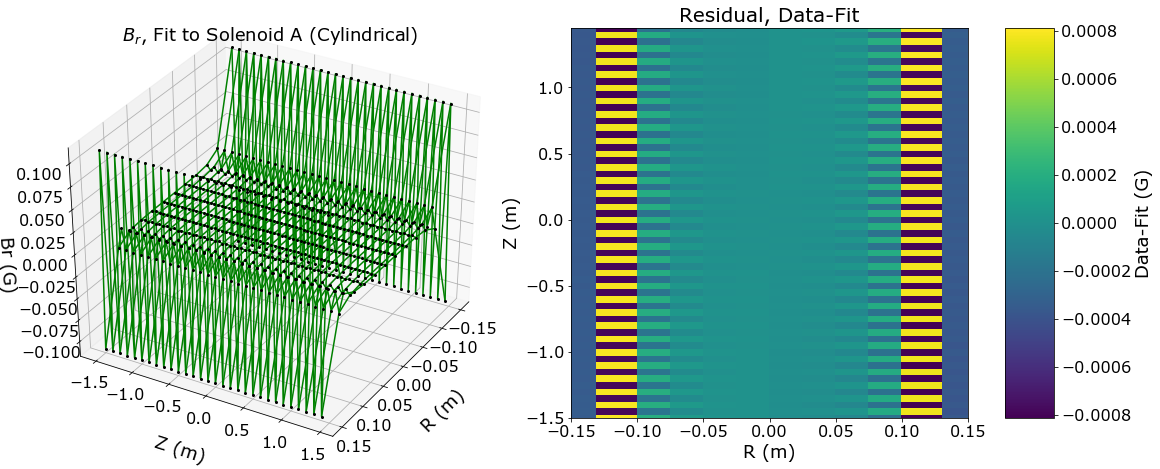

In [64]:
phi=0
fig = mu2e_plot3d(ff_cyl.input_data, 'R', 'Z', 'Br', f'R<=0.15 and Phi=={phi} and -2<Z<2',
            title_simp = r'$B_{r}$, Fit to Solenoid A (Cylindrical)', df_fit=True, mode='mpl', ptype='3d', units='m', aspect='rect2', do2pi=True)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/cyl_br_A_fit.png', bbox_inches='tight')

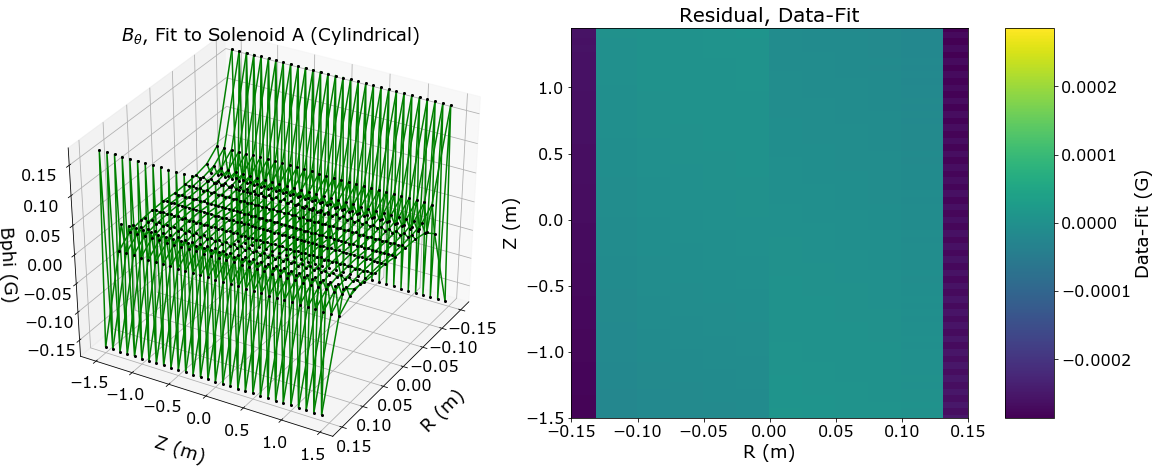

In [65]:
phi=0
fig = mu2e_plot3d(ff_cyl.input_data, 'R', 'Z', 'Bphi', f'R<=0.15 and Phi=={phi} and -2<Z<2',
            title_simp = r'$B_{\theta}$, Fit to Solenoid A (Cylindrical)', df_fit=True, mode='mpl', ptype='3d', units='m', aspect='rect2', do2pi=True)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/cyl_bt_A_fit.png', bbox_inches='tight')

# Validation

## Helical Validation

In [55]:
cfg_pickle_Hel_fs = cfg_pickle(use_pickle=False, save_pickle=True,
                             load_name='solA_fit_val', save_name='solA_fit_val', recreate=True)
_, ff_fullsim = field_map_analysis('fma_fit_solA_val', cfg_data_Cole_250mm_long_cyl_hg,
                                  cfg_geom_Cole_250mm_cyl_hg, cfg_params_Hel,
                                  cfg_pickle_Hel_fs, cfg_plot_none)
df_fs_hel =ff_fullsim.input_data

recreating fit with func_version=1000,
cfg_params(pitch1=0.1, ms_h1=2, ns_h1=3, pitch2=0, ms_h2=0, ns_h2=0, length1=0, ms_c1=0, ns_c1=0, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.1, 0.1, 4), version=1000)
Elapsed time was 7.89323 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 1088640
    # variables        = 0
    chi-square         = 0.00041
    reduced chi-square = 0.00000
    Akaike info crit   = -23635702.27995
    Bayesian info crit = -23635702.27995
[[Variables]]
    pitch1:    0.1 (fixed)
    ms_h1:     2 (fixed)
    ns_h1:     3 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   0 (fixed)
    ms_c1:     0 (fixed)
    ns_c1:     0 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ah1_0_0:   0 (fixed)
    Bh1_0_0:   0 (fixed)
    Ch1_0_0:  -5.122011e-12 (fixed)
    Dh1_0

In [56]:
cfg_pickle_Cyl_fs = cfg_pickle(use_pickle=False, save_pickle=True,
                             load_name='solA_fit2_val', save_name='solA_fit2_val', recreate=True)
_, ff_fullsim = field_map_analysis('fma_fit2_solA_val', cfg_data_Cole_250mm_long_cyl_hg,
                                  cfg_geom_Cole_250mm_cyl_hg, cfg_params_Cyl,
                                  cfg_pickle_Cyl_fs, cfg_plot_none)
df_fs_cyl =ff_fullsim.input_data

recreating fit with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=0.05, ms_c1=1, ns_c1=21, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 768}, bs_tuples=((0.25, 0, -46), (0.25, 0, 46)), bs_bounds=(0.001, 0.001, 3), version=1000)
Elapsed time was 9.55728 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 1088640
    # variables        = 0
    chi-square         = 212473702.41125
    reduced chi-square = 195.17352
    Akaike info crit   = 5741366.53899
    Bayesian info crit = 5741366.53899
[[Variables]]
    pitch1:     0 (fixed)
    ms_h1:      0 (fixed)
    ns_h1:      0 (fixed)
    pitch2:     0 (fixed)
    ms_h2:      0 (fixed)
    ns_h2:      0 (fixed)
    length1:    0.05 (fixed)
    ms_c1:      1 (fixed)
    ns_c1:      21 (fixed)
    length2:    0 (fixed)
    ms_c2:      0 (fixed)
    ns_c2:      0 (fixed)
    Ac1_0_0:    0 (fixed)
    Bc1_0_0:    0 (fixed)
    Dc1_0:      1

# Residuals

In [79]:
df_fs_cyl.eval('Bmag = (Bz**2+Br**2+Bphi**2)**(1/2)', inplace=True)
df_fs_cyl.eval('Bmag_fit = (Bz_fit**2+Br_fit**2+Bphi_fit**2)**(1/2)', inplace=True)
df_fs_hel.eval('Bmag = (Bz**2+Br**2+Bphi**2)**(1/2)', inplace=True)
df_fs_hel.eval('Bmag_fit = (Bz_fit**2+Br_fit**2+Bphi_fit**2)**(1/2)', inplace=True)

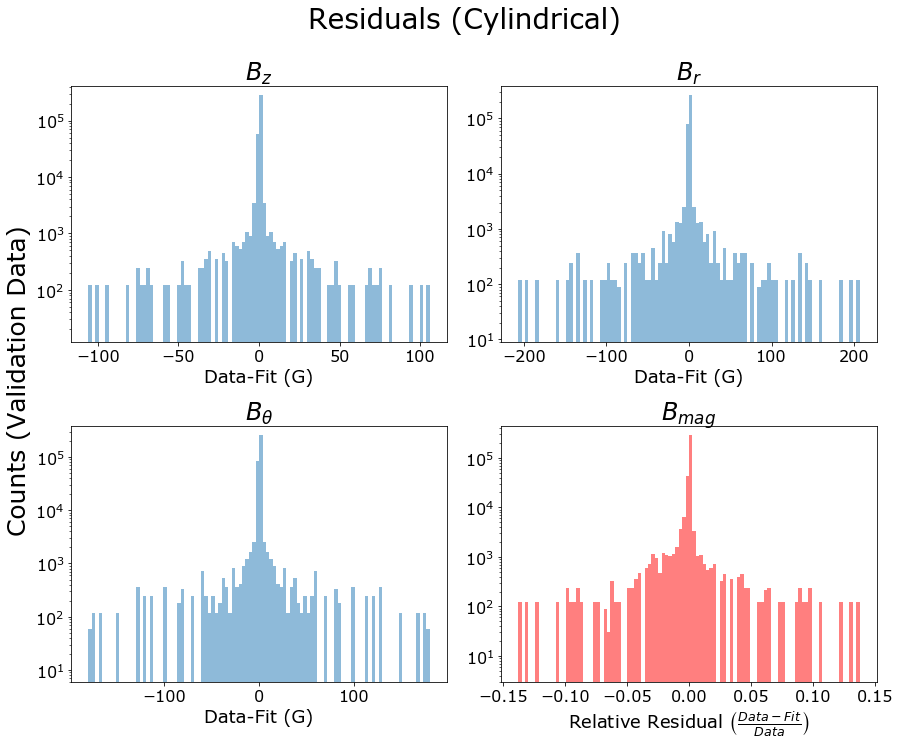

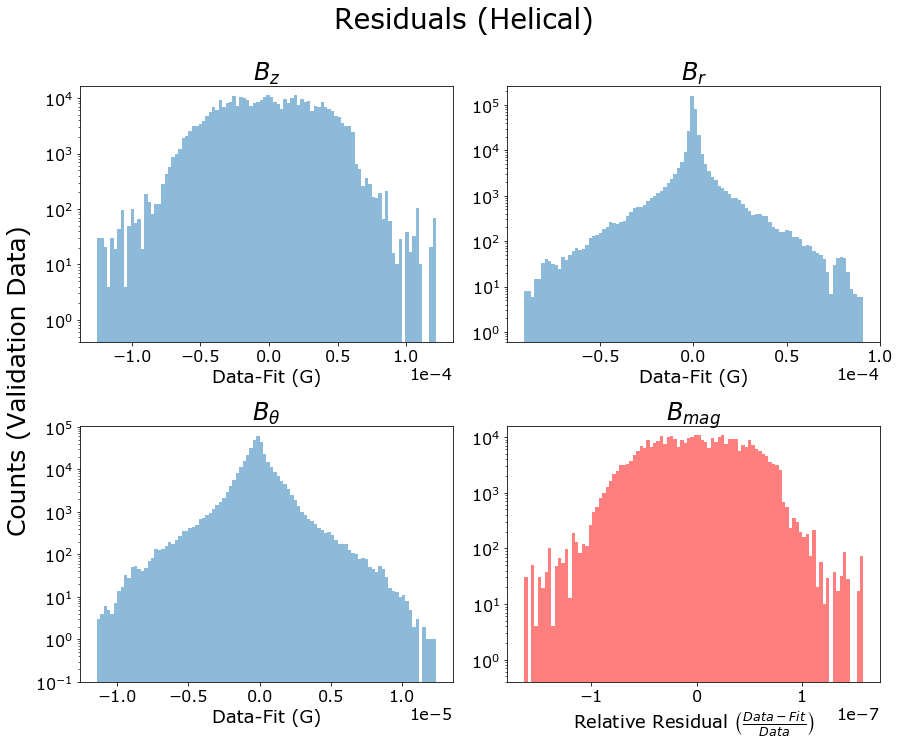

In [100]:
#fig = plt.figure(figsize=plt.figaspect(0.3))
# fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)
#fig.text(0.5,0.01, "Data-Fit (G)", ha="center", va="center", fontsize=18)
#ax = fig.add_subplot(2, 2, 1)
_ = splt.hist((df_fs_cyl.Bz-df_fs_cyl.Bz_fit), ax=axs[0][0], bins=100, log=True)
axs[0][0].set_title(r'$B_z$', fontsize=24)
#axs[0][0].set_ylabel('Counts')
axs[0][0].set_xlabel('Data-Fit (G)')
_ = splt.hist((df_fs_cyl.Br-df_fs_cyl.Br_fit), ax=axs[0][1], bins=100, log=True)
axs[0][1].set_title(r'$B_r$', fontsize=24)
axs[0][1].set_xlabel('Data-Fit (G)')
_ = splt.hist((df_fs_cyl.Bphi-df_fs_cyl.Bphi_fit), ax=axs[1][0], bins=100, log=True)
axs[1][0].set_title(r'$B_{\theta}$', fontsize=24)
axs[1][0].set_xlabel('Data-Fit (G)')
_ = splt.hist((df_fs_cyl.Bmag-df_fs_cyl.Bmag_fit)/df_fs_cyl.Bmag, ax=axs[1][1], bins=100, log=True, color='r')
axs[1][1].set_title(r'$B_{mag}$', fontsize=24)
axs[1][1].set_xlabel(r'Relative Residual $\left(\frac{Data-Fit}{Data}\right)$')
fig.suptitle('Residuals (Cylindrical)', verticalalignment='bottom', fontsize=28)
fig.text(-0.015,0.5, "Counts (Validation Data)", ha="center", va="center", rotation=90, fontsize=25)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/res_solA_cyl.pdf', bbox_inches='tight')

fig, axs = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)
#fig.text(0.5,0.01, "Data-Fit (G)", ha="center", va="center", fontsize=18)
#ax = fig.add_subplot(2, 2, 1)
_ = splt.hist((df_fs_hel.Bz-df_fs_hel.Bz_fit), ax=axs[0][0], bins=100, log=True)
axs[0][0].set_title(r'$B_z$', fontsize=24)
axs[0][0].set_xlabel('Data-Fit (G)')
axs[0][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useOffset=False)
_ = splt.hist((df_fs_hel.Br-df_fs_hel.Br_fit), ax=axs[0][1], bins=100, log=True)
axs[0][1].set_title(r'$B_r$', fontsize=24)
axs[0][1].set_xlabel('Data-Fit (G)')
axs[0][1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useOffset=False)
_ = splt.hist((df_fs_hel.Bphi-df_fs_hel.Bphi_fit), ax=axs[1][0], bins=100, log=True)
axs[1][0].set_title(r'$B_{\theta}$', fontsize=24)
axs[1][0].set_xlabel('Data-Fit (G)')
axs[1][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useOffset=False)
_ = splt.hist((df_fs_hel.Bmag-df_fs_hel.Bmag_fit)/df_fs_hel.Bmag, ax=axs[1][1], bins=100, log=True, color='r')
axs[1][1].set_title(r'$B_{mag}$', fontsize=24)
axs[1][1].set_xlabel(r'Relative Residual $\left(\frac{Data-Fit}{Data}\right)$')
axs[1][1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useOffset=False)
fig.text(-0.015,0.5, "Counts (Validation Data)", ha="center", va="center", rotation=90, fontsize=25)
fig.suptitle('Residuals (Helical)', verticalalignment='bottom', fontsize=28)
plt.savefig('/Users/brianpollack/Documents/Notes_Papers/Helix/figs/res_solA_hel.pdf', bbox_inches='tight')

#fig = plt.figure(figsize=plt.figaspect(0.3), constrained_layout=False)
#fig.text(0.5,0.01, "Data-Fit (G)", ha="center", va="center", fontsize=18)
#ax = fig.add_subplot(1, 3, 1)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useOffset=False)
#_ = splt.hist((df_fs_hel.Bz-df_fs_hel.Bz_fit), ax=ax, bins=100, log=True, color='r')
#ax.set_title(r'$B_z$')
#ax.set_ylabel('Counts')
#ax = fig.add_subplot(1, 3, 2)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#_ = splt.hist((df_fs_hel.Br-df_fs_hel.Br_fit), ax=ax, bins=100, log=True, color='r')
#ax.set_title(r'$B_r$')
#ax = fig.add_subplot(1, 3, 3)
#ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#_ = splt.hist((df_fs_hel.Bphi-df_fs_hel.Bphi_fit), ax=ax, bins=100, log=True, color='r')
#ax.set_title(r'$B_{\theta}$')
#fig.suptitle('B Component Residuals (Helical)', verticalalignment='bottom')